## CS441: Applied ML - HW 3

### Part 1: Estimating PDFs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Whole image


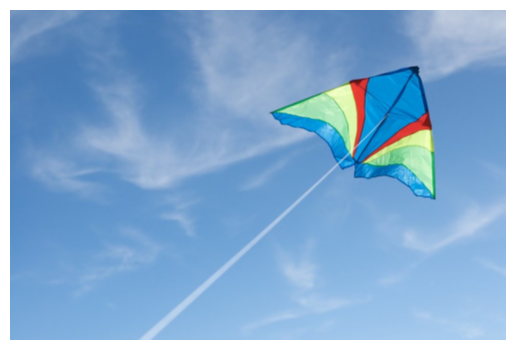

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Foreground


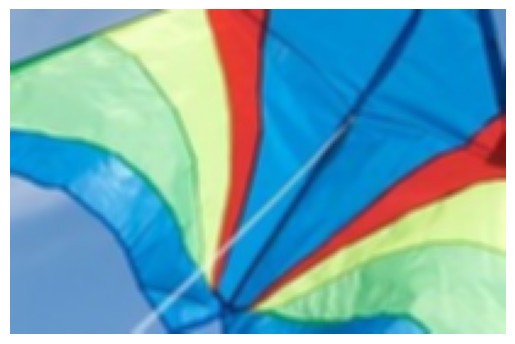

(532, 799)


In [93]:
# initalization code

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# from google.colab import drive
# from google.colab.patches import cv2_imshow
import cv2

# read images
# drive.mount('/content/drive')
datadir = ""
im = cv2.imread(datadir + 'kite.jpg')  # this is the full image
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255
im = cv2.blur(im, (3, 3))

crop = cv2.imread(datadir + 'kite_crop.jpg')  # this is the cropped image
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255
crop = cv2.blur(crop, (3, 3))

# displays a single image
def display_image(im):
  plt.imshow(im)
  plt.axis('off')
  plt.show()

# displays the image, score map, thresholded score map, and masked image
def display_score(im, score_map, thresh):
  display_image(im)
  display_image(np.reshape(score, (im.shape[:2])))
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  display_image(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)

print('Whole image')
display_image(im)

print('Foreground')
display_image(crop)
print(im.shape[:2])

#### Method 1 (per channel hist)

In [97]:
# estimate discrete pdf
def estimate_discrete_pdf(values, nvalues, prior=1, nbin = 10):
    '''
      Estimate P(values=v) for each possible v in (0, nvalues)
      Input:
         values: the values of the data
         nvalues: range of values, such that 0 <= values < nvalues
         prior: initial count used to prevent any value from having zero probability
      Output:
         p[nvalues,]: P(values=v) for each v
    '''
    n_bins = nbin
    ranges = np.arange(0, nvalues + (nvalues / n_bins), nvalues / n_bins) # n_bins + 1
    ranges[0] -= 0.1
    ranges[-1] += 0.1
    r, g, b = values[:,0], values[:,1], values[:,2]
    # res = np.ones(values.shape[0])
    res = None
    for v in [r,g,b]:
        binscount = [0] * n_bins
        # bins = [] # stores the index
        for nb in range(n_bins):
            cond = (v >= ranges[nb]) & (v < ranges[nb + 1])
            # bins.append(np.argwhere(cond))
            binscount[nb] = (cond).sum()
        
        # vprob = np.zeros(len(v))
        # for nb in range(n_bins):
        #     vprob[bins[nb]] = binscount[nb] / len(v)

        vprob = np.array(binscount) / len(v)
        res.append(vprob)
    return res[0], res[1], res[2], ranges
    
# TO DO

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(425068, 3)


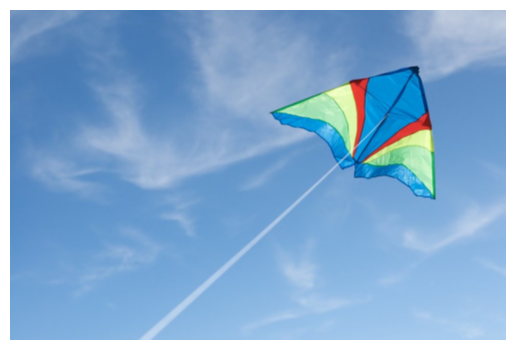

ValueError: cannot reshape array of size 0 into shape (532,799)

In [98]:
NBIN = 10
# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))

# estimate PDFs and compute score per pixel
imrscore, imgscore, imbscore, ranges = estimate_discrete_pdf(im_3, np.max(im_3), prior = 1, nbin = NBIN)
crscore, cgscore, cbscore, _ = estimate_discrete_pdf(crop_3, np.max(crop_3), prior = 1, nbin = NBIN)

digitized_im = np.digitize(im_3, ranges)

print(digitized_im.shape)
# score = np.log(crop_score / im_score)
t = -1
display_score(im=im, score_map=score, thresh=t)

#### Method 2 (Kmeans)

In [ ]:
# init
!apt install libomp-dev > /dev/null 2>&1
!pip install faiss-cpu > /dev/null 2>&1
import faiss

In [ ]:
# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))

# estimate PDFs and compute score per pixel

# TO DO

t= -1
display_score(im=im, score_map=score, thresh=t)

#### Method 3 (GMM)

In [ ]:
from sklearn.mixture import GaussianMixture

# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))


# estimate PDFs and compute score per pixel (can use gmm.score_samples where gmm is the mixture model)

# TO DO

t= -1
display_score(im=im, score_map=score, thresh=t)

## Part 2: Robust Estimation

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/24SP/hw3/"

# load data
T = np.load(datadir + 'salary.npz')
(salary, years, school) = (T['salary'], T['years'], T['school'])

#### 1. No noise
Compute the statistics for the data as a whole

In [ ]:
# TO DO

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max)

#### 2. Percentiles
Assume valid data will fall between the 5th and 95th percentile.

In [ ]:
pct = 0.05

# TO DO

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max)

#### 3. EM
Assume valid data follows a Gaussian distribution, while the fake data has a uniform distribution between the minimum and maximum value of salary.

In [ ]:

# TO DO


print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max)

# print the first five indices of salaries that are not likely to be valid
print(np.where(p_valid_given_s<0.5)[0][:5])

## Part 4: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

In [ ]:
# TO DO (optional)

In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")